In [5]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg
import time

import sys
sys.path.insert(0, '..')
import specsens as ss

Theory     pfa 0.1
Theory     pd  0.9608106474202457
Threshold is: 1065.2178104514555 with 1024 samples
   infs left at  0.00%
 15.31s left at  1.00%
 15.11s left at  2.00%
 15.29s left at  3.00%
 14.70s left at  4.00%
 15.08s left at  5.00%
 14.37s left at  6.00%
 14.51s left at  7.00%
 14.25s left at  8.00%
 14.25s left at  9.00%
 13.89s left at 10.00%
 14.04s left at 11.00%
 13.55s left at 12.00%
 13.52s left at 13.00%
 13.26s left at 14.00%
 14.18s left at 15.00%
 13.33s left at 16.00%
 12.96s left at 17.00%
 12.61s left at 18.00%
 12.50s left at 19.00%
 12.20s left at 20.00%
 12.59s left at 21.00%
 11.98s left at 22.00%
 12.14s left at 23.00%
 11.61s left at 24.00%
 11.54s left at 25.00%
 11.31s left at 26.00%
 11.27s left at 27.00%
 11.07s left at 28.00%
 10.99s left at 29.00%
 10.80s left at 30.00%
 10.71s left at 31.00%
 10.38s left at 32.00%
 10.37s left at 33.00%
 10.09s left at 34.00%
 10.06s left at 35.00%
  9.84s left at 36.00%
  9.91s left at 37.00%
  9.50s left at 38.00%

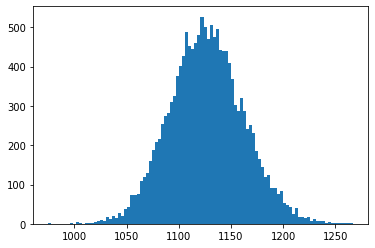

Box Sig Mean=1126.719, Standard Deviation=35.400


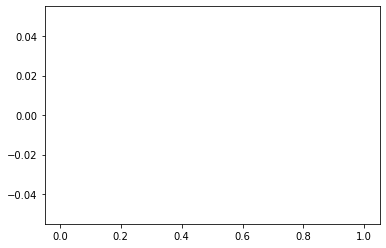

Flat Sig Mean=nan, Standard Deviation=nan


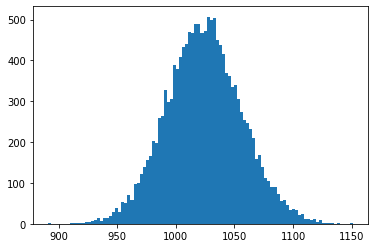

Box Noise Mean=1023.881, Standard Deviation=32.164


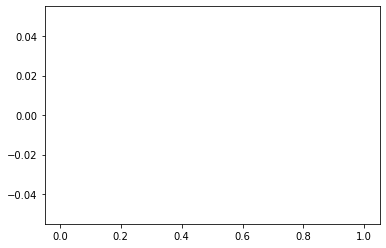

Flat Noise Mean=nan, Standard Deviation=nan


/home/fabian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:181: RuntimeWarning: invalid value encountered in double_scalars


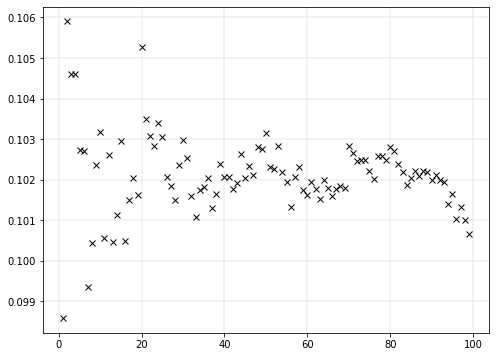

Theory     pfa 0.1
Simulation pfa 0.1007332506459271
Theory     pd  0.9608106474202457
Simulation pd  0.9628393874642573
Threshold      1065.2178104514555


In [21]:
n_bands = 1
band_to_detect = 0
n_fft = 1024
n_stats = 1024 // n_bands

class MonteCarloSim():
    def __init__(self, gens, itrs):
        self.gens = gens  # Number of generations
        self.itrs = itrs  # NUmber of iterations per generation
        self.reset()

    def reset(self):
        self.pfas = list()  # Probability of false alarm list
        self.pds = list()  # Probability of detection list
        self.en_box_sig = list()
        self.en_box_noise = list()
        self.en_flat_noise = list()
        self.en_flat_sig = list()
        self.time = None

    def run(self,
            signal_strength=0.,
            noise_strength=0.,
            sample_freq=1e6,
            length=1.,
            pre_pfa=0.1):

        self.reset()

#         n_samples = ss.util.get_signal_length(f_sample=sample_freq,
#                                               t_sec=length)
        n_samples = n_stats
        thr = ss.chi2_stats.get_thr(
            noise_power=noise_strength,
            pfa=pre_pfa,
            n=n_samples,
            dB=True)
        print(f'Threshold is: {thr} with {n_samples} samples')
        
        # Generations loop
        for i in range(self.gens):

            wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length)
            wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)

            correct_hit = 0
            false_hit = 0
            correct_miss = 0
            false_miss = 0
            times_signal_present = 0

            # As soon as we introduce noise uncertainty, the detector performs badly
            # This is expected, as energy detectors cant handle noise uncertainty
            # noise_uncertainty = np.random.uniform(-1., 1.)
            noise_uncertainty = 0.
            
            # Iterations loop
            for j in range(self.itrs):
                
                # Generate signal and noise
                sig = wm.get_soft(f_center=4e5, dB=signal_strength)
                noise = wgn.get_signal(dB=noise_strength + noise_uncertainty)
                
                # Randomly decide whether signal should be present
                sig_present = bool(np.random.randint(2))
                if sig_present:
                    both = sig + noise
                    times_signal_present += 1
                else:
                    both = noise

                # Classic energy detector
                eng = ss.EnergyDetector.get(both)
                
                # Mutliband stft based energy detector
#                 sft = ss.Stft(
#                     n=n_fft,
#                     window='flattop')  # currently only working with box window
#                 f, psd = sft.stft(sig=both[100:1124],
#                                   f_sample=sample_freq,
#                                   normalized=False,
#                                   dB=False)
#                 edf = ss.FreqEnergyDetector(num_bands=n_bands,
#                                             f_sample=1e6,
#                                             fft_len=n_fft,
#                                             freqs=f)
#                 eng = edf.detect(psd)[band_to_detect]
                
#                 if sig_present:
#                     self.en_flat_sig.append(eng)
#                 else:
#                     self.en_flat_noise.append(eng)
                
#                 sft = ss.Stft(
#                     n=n_fft,
#                     window='box')  # currently only working with box window
#                 f, psd = sft.stft(sig=both[100:1124],
#                                   f_sample=sample_freq,
#                                   normalized=False,
#                                   dB=False)
#                 edf = ss.FreqEnergyDetector(num_bands=n_bands,
#                                             f_sample=1e6,
#                                             fft_len=n_fft,
#                                             freqs=f)
#                 eng = edf.detect(psd)[band_to_detect]
                
                if sig_present:
                    self.en_box_sig.append(eng)
                else:
                    self.en_box_noise.append(eng)
                
#                 plt.figure(figsize=(8, 6))
#                 plt.plot(f, psd)
#                 plt.show()
                    
                # Threshold
                sig_detected = eng > thr
                
                
                # Log signal and detection outcome
                if sig_present and sig_detected:
                    correct_hit += 1
                elif sig_present and not sig_detected:
                    false_miss += 1
                elif not sig_present and sig_detected:
                    false_hit += 1
                else:
                    correct_miss += 1
            
            # Compute stats and store in list
            pfa_tmp = false_hit / (self.itrs - times_signal_present)
            pd_tmp = correct_hit / times_signal_present
            self.pfas.append(pfa_tmp)
            self.pds.append(pd_tmp)
            
            # Print simulation progress
            rem, per = self.runtime_stats(self.gens, i)
            print('%6.2fs left at %5.2f%%' % (rem, per))
        
        # Compute stats from list 
        pfa = np.sum(self.pfas) / self.gens
        pd = np.sum(self.pds) / self.gens
        
#         plt.figure(figsize=(8, 6))
#         plt.plot(self.energys)
#         plt.show()
        
        plt.hist(self.en_box_sig, bins=100)
        plt.show()
        print('Box Sig Mean=%.3f, Standard Deviation=%.3f' % (np.mean(self.en_box_sig), np.std(self.en_box_sig)))
        
        plt.hist(self.en_flat_sig, bins=100)
        plt.show()
        print('Flat Sig Mean=%.3f, Standard Deviation=%.3f' % (np.mean(self.en_flat_sig), np.std(self.en_flat_sig)))
        
        plt.hist(self.en_box_noise, bins=100)
        plt.show()
        print('Box Noise Mean=%.3f, Standard Deviation=%.3f' % (np.mean(self.en_box_noise), np.std(self.en_box_noise)))
        
        plt.hist(self.en_flat_noise, bins=100)
        plt.show()
        print('Flat Noise Mean=%.3f, Standard Deviation=%.3f' % (np.mean(self.en_flat_noise), np.std(self.en_flat_noise)))

        return pfa, pd

    def runtime_stats(self, total_itr, current_itr):
        if self.time is None: # First iteration cant predict time
            self.time = time.time()
            return float('inf'), 0.0
        delta_time = time.time() - self.time
        self.time = time.time()
        remaining_itr = total_itr - current_itr
        remaining_time = delta_time * remaining_itr
        percent_done = current_itr / total_itr * 100.0
        return remaining_time, percent_done

    def print_convergence(self):
        plt.figure(figsize=(8, 6))
        plt.grid(linewidth=0.3)
        for i in range(self.gens):
            inter = np.sum(self.pfas[0:i]) / i
            plt.plot(i, inter, 'kx')
        plt.show()


signal_strength = -10.
noise_strength = 0.
theo_pfa = 0.1
length = 0.001024
sample_freq = 1e6

n_samples = n_stats
thr = ss.chi2_stats.get_thr(
    noise_power=noise_strength,
    pfa=theo_pfa,
    n=n_samples,
    dB=True)
theo_pd = ss.chi2_stats.get_pd(noise_strength, signal_strength, thr, n_samples, dB=True, bands=n_bands)
print(f'Theory     pfa {theo_pfa}')
print(f'Theory     pd  {theo_pd}')

sim = MonteCarloSim(100, 300)
pfa, pd = sim.run(signal_strength=signal_strength,
                  noise_strength=noise_strength,
                  sample_freq=sample_freq,
                  length=length,
                  pre_pfa=theo_pfa)

sim.print_convergence()

print(f'Theory     pfa {theo_pfa}')
print(f'Simulation pfa {pfa}')

n_samples = n_stats
thr = ss.chi2_stats.get_thr(
    noise_power=noise_strength,
    pfa=theo_pfa,
    n=n_samples,
    dB=True)
theo_pd = ss.chi2_stats.get_pd(noise_strength, signal_strength, thr, n_samples, dB=True, bands=n_bands)
print(f'Theory     pd  {theo_pd}')
print(f'Simulation pd  {pd}')
print(f'Threshold      {thr}')

In [ ]:
signal_fac = ss.util.dB_to_factor_power(signal_strength)
noise_fac  = ss.util.dB_to_factor_power(noise_strength) / n_bands
n_samples = n_stats
thr = ss.chi2_stats.get_thr(
    noise_power=noise_fac,
    pfa=theo_pfa,
    n=n_samples,
    dB=False)
theo_pd = ss.chi2_stats.get_pd(noise_fac, signal_fac, thr, n_samples, dB=False, bands=1)
print(f'Theory     pd  {theo_pd}')
print(f'Simulation pd  {pd}')
print(f'Threshold      {thr}')